In [1]:
import chromadb
from datasets import load_dataset
from tqdm import tqdm
import sys
import json
from dataset_embeddings import *
import yaml
import pandas as pd
import matplotlib.pyplot as plt

tqdm.pandas()
sys.path.append("../..")

with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)
RANDOM_SEED = config["RANDOM_SEED"]

# Preapre database and dataset

In [2]:
# Create database and collections
chroma_client = chromadb.PersistentClient("db/")
collection = chroma_client.get_or_create_collection(
    name="goemotions_train_cosine", metadata={"hnsw:space": "cosine"}
)

In [3]:
# read the dataset
set_ = "train"
run_number = 3
dataset = load_dataset(
    "go_emotions", "simplified"
)
dataset.set_format(type="pandas")
df = dataset[set_][:]

int2label = lambda x: dataset[set_].features["labels"].feature.int2str(x)
df["labels_text"] = df["labels"].apply(int2label)

In [4]:
# read the new dataset
df_new = pd.read_csv("../cleaning/run1/train_filtered.csv")

# Get embedddings and create DBs

In [5]:
tokenizer, model = init_model()

/Users/usamaahmed/miniconda3/envs/LEGO/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<All keys matched successfully>


model running on mps


In [6]:
# run embedding model
batch_size = 64
embeddings = []
# iterate through the dataset
for i in tqdm(range(0, len(df), batch_size)):
    batch = list(df.iloc[i : i + batch_size]["text"])
    embeddings += (get_text_embeddings(batch, model, tokenizer, batch = True))

100%|██████████| 679/679 [02:42<00:00,  4.19it/s]


In [11]:
# insert into the database
for i in tqdm(range(len(df))):
    text = df.iloc[i]["text"]
    embedding = embeddings[i]
    collection.upsert(
        ids = [str(i)],
        documents = [text],
        embeddings = embedding,
    )

100%|██████████| 43410/43410 [00:50<00:00, 856.94it/s]


# Extract Duplicates

In [12]:
collection_dict = {}
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25]
for threshold in thresholds:
    print(f"Threshold: {threshold}")
    similars_dict = {}
    for i in tqdm(range(len(df))):
        results = get_similars(df, collection, idx=i, n_results=5)
        distances = [r["distance"] for r in results]
        # any distance < 0.15 is considered similar, add it to the similars_dict with key i
        results_list = [r["idx"] for r in results[1:] if r["distance"] < threshold]
        if results_list:
            similars_dict[i] = results_list
        collection_dict[threshold] = similars_dict

with open("duplicates.json", "w") as f:
    json.dump(collection_dict, f)

Threshold: 0.05


100%|██████████| 43410/43410 [01:47<00:00, 403.12it/s]


Threshold: 0.1


100%|██████████| 43410/43410 [01:52<00:00, 386.79it/s]


Threshold: 0.15


100%|██████████| 43410/43410 [01:53<00:00, 383.04it/s]


Threshold: 0.2


100%|██████████| 43410/43410 [01:51<00:00, 390.25it/s]


Threshold: 0.25


100%|██████████| 43410/43410 [01:47<00:00, 404.78it/s]


In [17]:
# Assuming similar_dicts is your dictionary
with open("duplicates.json", "r") as f:
    collection_dict = json.load(f)

# Agreements

In [18]:
from itertools import combinations

def calculate_agreement(list_of_lists):
    # Weight is used since more labels means more chances of overlap
    def length_weighted_jaccard_similarity(set1, set2):
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        jaccard = intersection / union if union else 0
        length_weight = min(len(set1), len(set2)) / max(len(set1), len(set2))
        return jaccard * length_weight
    
    # Convert inner lists to sets
    sets = [set(inner_list) for inner_list in list_of_lists]
    
    # Calculate pairwise Length-Weighted Jaccard similarities
    pair_similarities = [length_weighted_jaccard_similarity(s1, s2) for s1, s2 in combinations(sets, 2)]
    
    # Calculate the average similarity
    average_similarity = sum(pair_similarities) / len(pair_similarities) if pair_similarities else 0
    
    return average_similarity

In [19]:
def find_agreement(df, column, similars_dict):
    keys = list(similars_dict.keys())
    agreements = []
    for key in keys:
        indices = list([key]) + similars_dict[key]
        labels = list(df.iloc[indices][column])
        agreements.append(calculate_agreement(labels))
    avg_agreements = sum(agreements) / len(agreements)
    return agreements, avg_agreements

In [20]:
def get_examples(index, duplicates_dict, df = df ,df_new = df_new, df_column = "labels_text", df_new_column = "parsed_predictions"):
    index = list(duplicates_dict.keys())[index]
    indices = [int(index)] + duplicates_dict[index]
    example_text = df.iloc[indices]["text"]
    example_labels = df.iloc[indices][df_column]
    example_new_labels = df_new.iloc[indices][df_new_column]
    # convert these dicts into a dataframe
    examples = pd.DataFrame({"text": example_text, "labels": example_labels, "new_labels": example_new_labels})
    return examples

In [22]:
# Test some example
idx = 14
print(get_examples(idx, collection_dict["0.1"]))
print(calculate_agreement(get_examples(idx, collection_dict["0.1"])["labels"]))
print(calculate_agreement(get_examples(idx, collection_dict["0.1"])["new_labels"]))

              text     labels                 new_labels
283     Hi [NAME]!  [neutral]      ['neutral', 'caring']
31603   Hi [NAME]!  [neutral]                ['neutral']
43261  Hi, [NAME]!  [neutral]  ['neutral', 'excitement']
1.0
0.5357094226579521


In [23]:
def get_averages(df, column):
    averages = {}
    agreements_lists = {}
    for key in collection_dict.keys():
        similars_dict = collection_dict[key]
        similars_dict = {int(k): v for k, v in similars_dict.items()}
        agreements, avg_agreements = find_agreement(df, column, similars_dict)
        averages[key] = avg_agreements
        agreements_lists[key] = agreements
    return averages, agreements_lists

In [24]:
averages_cosine, _ = get_averages(df, "labels_text")
averages_cosine_new, _ = get_averages(df_new, "parsed_predictions")

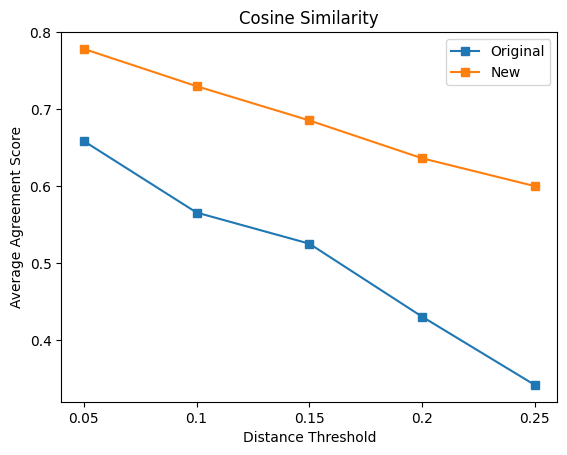

In [25]:
plt.plot(averages_cosine.keys(), averages_cosine.values(), label = "Original", marker = "s")
plt.plot(averages_cosine_new.keys(), averages_cosine_new.values(), label = "New", marker = "s")
plt.xlabel("Distance Threshold")
plt.ylabel("Average Agreement Score")
plt.title("Cosine Similarity")
plt.legend()

# Get list of duplicates (to be dropped)

In [37]:
threshold = 0.13
similars_dict = collection_dict[str(threshold)]
to_be_dropped = set()
for key, values in similars_dict.items():
    if key in to_be_dropped:
        continue
    for value in values:
        to_be_dropped.add(value)

print(len(to_be_dropped))

# save it to txt_file
# with open(f"duplicates_{str(threshold)}.txt", "w") as f:
#     f.write(",".join(map(str, to_be_dropped)))

# read from txt file
# with open(f"duplicates_{str(threshold)}.txt", "r") as f:
#     to_be_dropped = set(map(int, f.read().split(",")))

2742
